# Jacobi Iteration Example (inspired by "Painless Conjugate Gradient")

There are many iterative methods to solving the equation $Ax=b$. One such method is the Jacobi iteration. Suppose you have a matrix $A$. Then you can decompose $A$ as the sum of it's diagonal and off-diagonal elements and reach the following identity. 

\begin{gather}
Ax = b \\
(D+E)x=b \\
Dx+Ex=b \\
Dx=-Ex+b \\
x=-D^{-1}Ex+D^{-1}b \\
x=Bx+z
\end{gather}

From this, we could define a recurrence relation for an iterative method as follows. If we define an iterative step $x_{i}=x_{true}+e_{i}$ as the sum of the true solution and its error, we can gain further insight 

\begin{gather}
x_{i+1}=Bx_{i}+z \\ 
x_{true} + e_{i+1} = B(x_{true}+e_{i})+z \\
(Bx_{true}+z)+e_{i+1}=Bx_{true}+Be_{i}+z \\ 
e_{i+1}=Be_{i}
\end{gather}

What this iteration does is isolate the errors of each iterative step. Each step of the iteration, the matrix $B=-D^{-1}E$ acts on the previous
error. If the goal is to get our error down towards zero, then as with all matrix iterations, we would want the spectral 
radius of $B$, or the magnitude of the largest eigenvalue $\rho(B)=|\lambda_1|\leq 1$

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import numpy as np

In [129]:
def Jacobi(A, B, X, maxIter):
    """
    Jacobi iteration for strictly diagonally dominant matrices
    
    Parameters:
        A -- data matrix (m x n)
        X -- starting guesses (n x nrhs)
        B -- right hand side (m x nrhs)
        maxIter -- maximum number of steps

    Returns:
        X -- solutions (n x nrhs)
        his -- convergence history. Value of loss function at each iteration (maxIter x 1)
        grad -- gradient at each iteration (n x maxIter)
        Xall -- iterates at every iteration (n x nrhs x maxIter)
    """
    n = A.shape[1]
    nrhs = B.shape[1]
    
    his = np.zeros(maxIter)
    grad = np.zeros((n,maxIter))
    Xall = np.zeros((n, nrhs, maxIter+1))
    Xall[:,:,0] = X
    
    D = np.diag(A)
    E = A - np.diag(D)
    D_inv =  (1 / D)[np.newaxis].T

    for i in np.arange(maxIter):
        r = B - (A @ X)
        gradient = A.T @ r
        his[i] = np.linalg.norm(r)
        grad[:,i] = gradient.T
        X = (-D_inv * E) @ X + D_inv * B
        for j in np.arange(nrhs):
            Xall[:,j,i+1] = X[:,j]
    
    return X, his, grad, Xall

In [130]:
def SDLS(A, B, X, maxIter):
    """
    Steepest descent for least squares with exact line search.
    
    Parameters:
        A -- data matrix (m x n)
        X -- starting guesses (n x nrhs)
        B -- right hand side (m x nrhs)
        maxIter -- maximum number of steps

    Returns:
        X -- solutions (n x nrhs)
        his -- convergence history. Value of loss function at each iteration (maxIter x 1)
        grad -- gradient at each iteration (n x maxIter)
        Xall -- iterates at every iteration (n x nrhs x maxIter)
    """
    n = A.shape[1]
    nrhs = B.shape[1]

    his = np.zeros(maxIter)
    grad = np.zeros((n, maxIter))
    Xall = np.zeros((n, nrhs, maxIter+1))
    Xall[:,:,0] = X
    
    for i in np.arange(maxIter):
        r = B - (A @ X)
        his[i] = np.linalg.norm(r)
        d = A.T @ r
        grad[:,i] = d.T
        Ad = A @ d
        alpha = (r.T @ Ad) / np.linalg.norm(Ad)**2
        X = X + d @ alpha
        for j in np.arange(nrhs):
            Xall[:,j,i+1] = X[:,j]
    
    return X, his, grad, Xall

We'll set up a problem with the following test matrices, and see what Jacobi converges to. 

\begin{gather}
A=
\begin{bmatrix}
    3 & 2 \\
    2 & 6
\end{bmatrix}
, b=
\begin{bmatrix}
    2 \\
    -8
\end{bmatrix}
, x_0=
\begin{bmatrix}
    0 \\
    0
\end{bmatrix}
\end{gather}

In [131]:
A = np.array([[3,2],[2,6]])
B = np.array([[2,-8]]).T
X = np.zeros_like(B)

X_J, his_J, grad_J, Xall_J = Jacobi(A, B, X, 30)
X_SD, his_SD, grad_SD, Xall_SD = SDLS(A, B, X, 30)

In [132]:
def _f(x, A, B):
    x = x[np.newaxis].T
    r = (A @ x) - B
    return np.linalg.norm(r)

def generate_contour(A, B, Xall, x1min, x1max, x2min, x2max, num_x1=100, num_x2=100):
    x1 = np.linspace(x1min, x1max, num_x1)
    x2 = np.linspace(x2min, x2max, num_x2)
    X1_grid, X2_grid = np.meshgrid(x1, x2)
    x = np.reshape(X1, num_x1*num_x2)
    y = np.reshape(X2, num_x1*num_x2)
    Z = np.reshape(np.apply_along_axis(func1d=_f, axis=0, arr=np.vstack((x,y)), A=A, B=B), (num_x1,num_x2))
    X1_path = Xall[0][0]
    X2_path = Xall[1][0]
    return Z, X1_grid, X2_grid, X1_path, X2_path

In [135]:
Z_SD, X1_SD_grid, X2_SD_grid, X1_SD_path, X2_SD_path = generate_contour(A, B, Xall_SD, -2, 3, -3, 1)
Z_J, X1_J_grid, X2_J_grid, X1_J_path, X2_J_path = generate_contour(A, B, Xall_J, -2, 3, -3, 1)

Text(0, 0.5, 'X2')

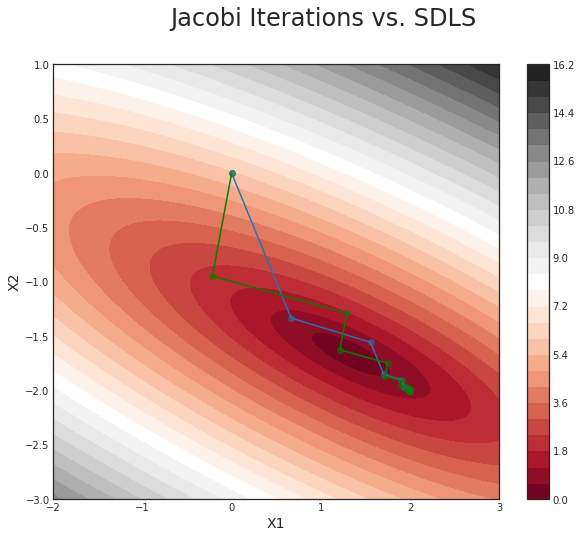

In [136]:
plt.figure(figsize=(10,8))
plt.suptitle("Jacobi Iterations vs. SDLS", fontsize=24)
plt.contourf(X1_J_grid, X2_J_grid, Z_J, 30, cmap='RdGy');
plt.colorbar();
plt.scatter(X1_J_path, X2_J_path, alpha=0.5)
plt.plot(X1_J_path, X2_J_path)
plt.scatter(X1_SD_path, X2_SD_path, alpha=0.5, c="g")
plt.plot(X1_SD_path, X2_SD_path, c="g")
plt.xlabel("X1",fontsize=14)
plt.ylabel("X2",fontsize=14)

1. What happens if $A$ is singular?
2. What happens if $\rho(A) \geq 1$?
3. What happens if $A$ is not diagonally dominant? 

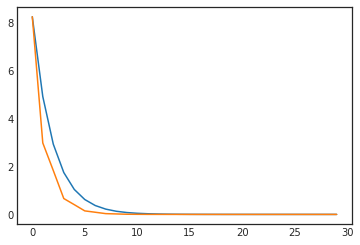

In [138]:
plt.plot(his_SD)
plt.plot(his_J)

In [143]:
_f(X_SD, A, B)

1.5072484693874052e-06

In [144]:
_f(X_J, A, B)

1.3124014337385523e-09